# Final Project

## Project Structure

This project is divided into 5 parts:
1. Background
2. Data Inspection
3. SVM
4. Logistic Regression 
5. Methods with PCA

## Background

Our goal of this project is to improve ways of pre-judging Alzheimer’s by studying brain Atlas/brain Percolation Data based on MIT's [project](https://github.com/chuktuk/Alzheimers_Disease_Analysis/tree/8a182f3e4ab2b4b88b48294186ece2fa81131cb9). The data set we used are from ADNI [website](http://adni.loni.usc.edu/data-samples/access-data/). Until now we have find three ways of imporing the existing work:
1. Using SVM
2. Using CNN
3. Applying PCA to pre-process data

## Data Inspection

### Introduction
AD is the most expensive disease in America according to the [Alzheimer’s Association](alz.org), therefore, we are trying to find ways of pre-judging Alzheimer’s by studying related dataset. This dataset was chosen because it contains information collected from the same patients over multiple exams that were conducted years apart in many cases.

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# import wrangle_adni to import/wrangle the data
from adnidatawrangling import wrangle_adni

# import modules from MIT work called eda, sda, ml for exploratory/statistical data analysis
import eda, sda, ml

### Row Data 

We used the data from ADNIMERGE.csv, which were processed as follows:
1. Look into dataframes using `.head()`
2. As inspired by previous work, using `.isnull().sum()` and `isnull().mean()` to describe missing values
3. For more resonable data, we filted the data, with only patients with at least two exams performed remained
4. As pointed by previous work, `final_exam` containes columns for the baseline values for each biomarker, therefore, it is treated as a more meaningful dataframe

In [5]:
# import data, clean, and extract data
adni_comp, clin_data, scan_data = wrangle_adni()

In [6]:
# extract final exam data: only the last exam for each patient
final_exam = eda.get_final_exam(adni_comp)

In [8]:
# subset only the baseline data from the complete dataset
adni_bl, clin_bl, scan_bl = eda.get_bl_data(adni_comp, clin_data, scan_data)
final_exam.PTGENDER.value_counts()

Male      642
Female    528
Name: PTGENDER, dtype: int64

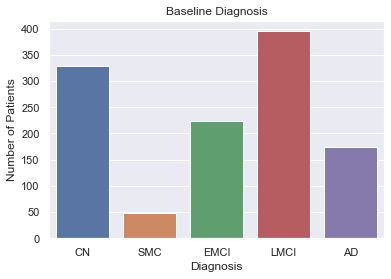

In [10]:
# plot baseline diagnosis
_ = eda.plot_bl_diag(adni_bl)

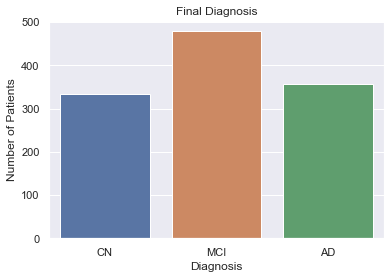

In [11]:
# plot the final diagnosis counts
_ = eda.plot_final_diag(adni_comp)

### Data Processing

To get valid training and testing data, we used the following method to processing the data:

In [27]:
from sklearn.model_selection import train_test_split

# import data, clean, and extract data
adni_comp, clin_data, scan_data = wrangle_adni()

# extract final exam data: only the last exam for each patient
final_exam = eda.get_final_exam(adni_comp)

# calculate the change in variables over the course of the study
eda.calc_deltas(final_exam)

# extract and scale the deltas data for ML analysis
feature_names, Xd, yd = ml.get_delta_scaled(final_exam)

# examine the structure of the data
print(feature_names.shape)
print(Xd.shape, yd.shape)

# split the data into test and train sets
Xd_train, Xd_test, yd_train, yd_test = train_test_split(Xd, yd, test_size=0.3, 
                                                    random_state=21, stratify=yd)

(12,)
(1134, 12) (1134,)


## SVM

We first tried to find a better SVM Model for the data, the MIT work used the following settings for SVM:

`C: 0.75, gamma: 0.08319742133210749`

And got a training accuracy: 0.8776796973518285 

and test accuracy: 0.8533724340175953

By preforming cross-valiation on different C and gamma values, our choice of SVM finally is `C=2.8, gamma=0.0073` with rbf kernel, and got an accuracy at 0.891496, which increased a little performance of the SVM model.

In [29]:
# newly constructed svm
from sklearn import svm
svc_tentative = svm.SVC(probability=False,  kernel="rbf", C=2.8, gamma=.0073, verbose=10)
svc_tentative.fit(Xd_train,yd_train)

yhat = svc_tentative.predict(Xd_test)
print('The test accuracy is: %f' % np.mean(yhat == yd_test))

[LibSVM]The test accuracy is: 0.891496


We can look into data from confusion matrix:

In [33]:
# print the confusion matrix
print(confusion_matrix(yd_test, yhat))
tn, fp, fn, tp = confusion_matrix(yd_test, yhat).ravel()
dr = tp / (tp + fn)
fpr = fp / (fp + tn)
print('True Negatives: {}'.format(tn))
print('False Positives: {}'.format(fp))
print('False Negatives: {}'.format(fn))
print('True Positives: {}'.format(tp))
print('Detection Rate: {}'.format(dr))
print('False Positive Rate: {}'.format(fpr))

[[277  10]
 [ 27  27]]
True Negatives: 277
False Positives: 10
False Negatives: 27
True Positives: 27
Detection Rate: 0.5
False Positive Rate: 0.03484320557491289


## Logistic Regression
We then tried method of Logistic Regression, for the work of MIT, they used:

In [39]:
from sklearn import linear_model
# build the model
logreg = linear_model.LogisticRegression(solver='lbfgs', class_weight='balanced', random_state=42)

# fit the model
logreg.fit(Xd_train, yd_train)

# generate predictions
y_pred = logreg.predict(Xd_test)

And got an accuracy at:

In [41]:
# print the accuracy
print('The training accuracy was: {}'.format(logreg.score(Xd_train, yd_train)))
print('The test accuracy was: {}'.format(logreg.score(Xd_test, yd_test)))

The training accuracy was: 0.8663303909205549
The test accuracy was: 0.8651026392961877


For us, we tried the following settings and got anaccuracy at:

In [42]:
# newly constructed module
logreg = linear_model.LogisticRegression(C=1e5, solver='liblinear')
logreg.fit(Xd_train,yd_train)

yhat = logreg.predict(Xd_test)
acc = np.mean(yhat == yd_test)
print('Accuracy on the test data is %7.5f' % acc)

Accuracy on the test data is 0.89150


Also print out the confusion matrix for reference:

In [44]:
print(confusion_matrix(yd_test, y_pred))
tn, fp, fn, tp = confusion_matrix(yd_test, y_pred).ravel()
dr = tp / (tp + fn)
fpr = fp / (fp + tn)
print('True Negatives: {}'.format(tn))
print('False Positives: {}'.format(fp))
print('False Negatives: {}'.format(fn))
print('True Positives: {}'.format(tp))
print('Detection Rate: {}'.format(dr))
print('False Positive Rate: {}'.format(fpr))

[[249  38]
 [  8  46]]
True Negatives: 249
False Positives: 38
False Negatives: 8
True Positives: 46
Detection Rate: 0.8518518518518519
False Positive Rate: 0.13240418118466898
